## Capstone Project 
# Sparkify Churn Prediction: 
### by Ajeet Kumar Verma    



<div>
<img src="sparkify.jpeg" width="400"/>
</div>

## Contents
* [Project Overview](#int)
* [Problem Statement](#prob)
* [Load and Clean Dataset](#load)
* [Exploratory Data Analysis](#eda)
* [Feature Engineering](#eng)
* [Modeling](#model)
* [Conclusions](#con)

## Project Overview
<a class="anchor" id="int"></a>

This is one of the parts of the capstone project in Udacity's data science Nanodgeree program. There is a virtual start-up company named Sparkify(similar to Spotify) that offers music streaming services to users in the USA. Many users stream their favorite songs every day either using the basic free tier that places advertisements between the songs or the premium subscription model, where they stream the music for free but pay a monthly flat rate. Users can upgrade, downgrade, or cancel their service at any time. So, it is crucial to make sure the users love the service. Every time a user interacts with the service such as playing songs, logging out, liking a song with a thumps-up, hearing an Ad, or downgrading their service, it generates data. All this data contains key insides for keeping the users happy and helping Sparkify’s business thrive. It is our job on the data team to predict which users are at risk to churn either downgrading from premium to free tier or canceling their service altogether. If we can accurately identify these users before they leave, Sparkify can offer them discounts and incentives, potentially saving the business millions in revenue.

Sparkify keeps a Log file with 18 fields for every user interaction (e.g., userId, name of the song played, length of a song played, name of artist). Soon, the log file data volume exceeded the available memory space on standard desktop computers, and the company opted for using the distributed file system Apache Spark™. Udacity™ provides the full dataset with 12GB on AWS™ S3, and you can run a Spark cluster on the cloud using AWS or IBM™ Cloud to analyse the large amount of data.


## Problem Statement
<a class="anchor" id="prob"></a>
The problem is to create a machine learning solution that can predict the user's intent to unsubscribe (Called customers' churn) before it happens in order to minimize the churn rate and provide better customer services.

Import the required libraries.

In [1]:
# import pyspark libraries and its APIs
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession, Row
from pyspark.sql.types import StringType, IntegerType
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.sql.functions import *

# import pyspark ML APIs
from pyspark.ml import Pipeline
from pyspark.ml.feature import CountVectorizer, IDF, PCA, RegexTokenizer, VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC, NaiveBayes
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# import other libraries
import re
import datetime
import time
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

Create Spark Session.

In [2]:
# create a entry point Spark session
spark = SparkSession.builder.master("local").appName("Sparkify Capstone Project").getOrCreate()

In [3]:
spark

In [4]:
spark.sparkContext.getConf().getAll()

[('spark.master', 'local'),
 ('spark.app.name', 'Sparkify Capstone Project'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.port', '40995'),
 ('spark.app.id', 'local-1668671076295'),
 ('spark.driver.host', '9d78db897f28')]

## Load and Clean Dataset
<a class="anchor" id="load"></a>
The provided mini-dataset file is `mini_sparkify_event_data.json`. First we need to load the dataset and clean it (check for invalid or missing data - for example, records with missing userids and/or sessionids. ) for further use.

In [5]:
# loading the dataset
df = spark.read.json("mini_sparkify_event_data.json")

In [6]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [7]:
df.take(3)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [8]:
# print the schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [9]:
df.describe().show()

+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|           length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|           userId|
+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|           228108|286500|           278154|286500| 286500|            

In [10]:
# get the count of the dataset
df.count()

286500

In [11]:
# stats for the column "artist"
df.describe("artist").show()

+-------+------------------+
|summary|            artist|
+-------+------------------+
|  count|            228108|
|   mean| 551.0852017937219|
| stddev|1217.7693079161374|
|    min|               !!!|
|    max| ÃÂlafur Arnalds|
+-------+------------------+



In [12]:
# stats of the column "sessionId"
df.describe("sessionId").show()

+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630741|
|    min|                1|
|    max|             2474|
+-------+-----------------+



In [13]:
# columns in the dataset
df.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId']

In [14]:
# for better visibility, we convert the dataframe into pandas df
pandas_df = df.toPandas()
pandas_df.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


The page which the userid with " " (empty string) visited

In [15]:
set(df.select(['userId', 'page']).where(df.userId=="").collect())

{Row(userId='', page='About'),
 Row(userId='', page='Error'),
 Row(userId='', page='Help'),
 Row(userId='', page='Home'),
 Row(userId='', page='Login'),
 Row(userId='', page='Register'),
 Row(userId='', page='Submit Registration')}

In [16]:
Counter(df.select(['userId', 'page']).where(df.userId=="").collect())

Counter({Row(userId='', page='Home'): 4375,
         Row(userId='', page='Help'): 272,
         Row(userId='', page='Login'): 3241,
         Row(userId='', page='About'): 429,
         Row(userId='', page='Error'): 6,
         Row(userId='', page='Register'): 18,
         Row(userId='', page='Submit Registration'): 5})

Users who are only visiting the About, Home and Login pages are most probably unregistered visitors.

In [17]:
# female users 
df.select('gender').where(df.gender=='F').count()

154578

In [18]:
# drop duplicates in userId
df.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



Looking at the dataframe, we can see that the if a single data point(row) has no value in the userId column then this data point is useless for further analysis. Similarly, if the sessionId is missing in a row then also it doesn't make any sense to process this data point.

Therefore, we check for missing or null values in the 'userId' and/or 'sessionId' columns and remove such rows from the dataframe.

In [19]:
# drop duplicates in sessionId
df.select("sessionId").dropDuplicates().sort("sessionId").show()

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
|        6|
|        7|
|        8|
|        9|
|       10|
|       11|
|       12|
|       13|
|       15|
|       16|
|       17|
|       18|
|       19|
|       20|
|       21|
+---------+
only showing top 20 rows



In [20]:
# remove the ones with an empty string userId
filtered_df = df.filter(df["userId"]!="")

In [21]:
filtered_df.count()

278154

### The new dataframe has 278154 data points which is **8346** (286500-278154) less than the original data size.

## Exploratory Data Analysis
<a class="anchor" id="eda"></a>

### Define Churn

A column `Churn` will be created to use as the label for our model. `Cancellation Confirmation` events is used to define churn, which happen for both paid and free users. We will assign a 1 where a user has churned and a 0 where they have not yet churned.

### Explore Data
Exploratory data analysis will  be performed to observe the behavior for users who stayed vs users who churned. Starting by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### Identification of the churned users

In [22]:
filtered_df.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



As can be seen above, there are many different types of pages. And which page leads or indicates that the user is going to churn is "Cancellation Confirmation".

In [23]:
filtered_df.select(["userId", "page"]).where(filtered_df.page == "Cancellation Confirmation").head(5)

[Row(userId='18', page='Cancellation Confirmation'),
 Row(userId='32', page='Cancellation Confirmation'),
 Row(userId='125', page='Cancellation Confirmation'),
 Row(userId='105', page='Cancellation Confirmation'),
 Row(userId='17', page='Cancellation Confirmation')]

In [24]:
# number of churned users
filtered_df.select(["userId", "page"]).where(filtered_df.page == "Cancellation Confirmation").count()

52

As we see that 52 users haved churned in the dataset. let's see those users with their userIds that have churened.

In [25]:
df.select(["userId", "page"]).where(df.page == "Cancellation Confirmation").show()

+------+--------------------+
|userId|                page|
+------+--------------------+
|    18|Cancellation Conf...|
|    32|Cancellation Conf...|
|   125|Cancellation Conf...|
|   105|Cancellation Conf...|
|    17|Cancellation Conf...|
|   143|Cancellation Conf...|
|   101|Cancellation Conf...|
|   129|Cancellation Conf...|
|   121|Cancellation Conf...|
|    51|Cancellation Conf...|
|    87|Cancellation Conf...|
|   122|Cancellation Conf...|
|    12|Cancellation Conf...|
|    58|Cancellation Conf...|
|    73|Cancellation Conf...|
|     3|Cancellation Conf...|
|   106|Cancellation Conf...|
|   103|Cancellation Conf...|
|    28|Cancellation Conf...|
|    54|Cancellation Conf...|
+------+--------------------+
only showing top 20 rows



We will now create a new column "Churn" to use it as the label for the model. The value under this column for a specific row depends on the page they have visited. If the visited page is "Cancellation Confirmation" means the user has churned. So the value will be 1 otherwise 0.

In [26]:
churn_func = udf(lambda pg: 1 if pg == "Cancellation Confirmation" else 0, IntegerType())

In [27]:
filtered_df.head(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

In [28]:
# create the 'Churn' column
filtered_df = filtered_df.withColumn("Churn", churn_func("page"))

In [29]:
filtered_df.head(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', Churn=0)]

In [30]:
filtered_df.toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,Churn
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0
5,The All-American Rejects,Logged In,Micah,M,81,Long,208.29995,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Don't Leave Me,200,1538352678000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0
6,The Velvet Underground / Nico,Logged In,Micah,M,82,Long,260.46649,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Run Run Run,200,1538352886000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0
7,Starflyer 59,Logged In,Colin,M,53,Freeman,185.44281,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Passengers (Old Album Version),200,1538352899000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0
8,None,Logged In,Colin,M,54,Freeman,NaN,paid,"Bakersfield, CA",PUT,Add to Playlist,1538173362000,29,None,200,1538352905000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0
9,Frumpies,Logged In,Colin,M,55,Freeman,134.47791,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Fuck Kitty,200,1538353084000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0


Now we can see that the new column "Churn" has been added to the dataframe based on the implemented logic.

In [31]:
# sort the data-points for a user in reverse time order 
window_val = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

In [32]:
# create the column 'Churn' containing the sum of churn 1s over records
filtered_df = filtered_df.withColumn("Churn", Fsum("Churn").over(window_val))

In [33]:
churned_df = filtered_df.select(['userId', 'Churn']).dropDuplicates().groupBy('Churn').count()

In [34]:
churned_df.show()

+-----+-----+
|Churn|count|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+



### Exploratory Data Analysis(EDA) for Churned vs Non-churned users

Now we have successfully added the column Churn to our dataset based on the page they've visited. So let's now analyse the data for the users who opted out vs the users who stayed in.

### Number of Non-churned and churned users 

In [35]:
churned_df = churned_df.toPandas()

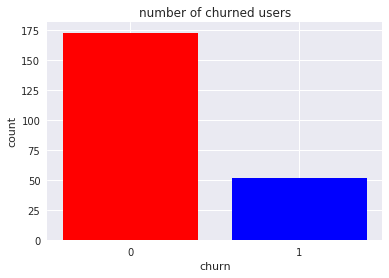

In [36]:
# # number of churned users
fig, ax = plt.subplots()
ax.bar(['0', '1'], churned_df['count'], color=['r', 'b'])
ax.set_xlabel('churn')
ax.set_ylabel('count')
plt.title('number of churned users')
plt.show()

### churn rate

In [37]:
churn_rate = (churned_df['count'][1]/(churned_df['count'][1]+churned_df['count'][0]))*100
churn_rate

23.111111111111111

it can be seen that 52 users have churned while the remaining 173 users didn't. Which means that 23% of our users churned.The important thing to note here is that the dataset is imbalanced.

### Length of stay of Churned and Non-churned users

We can now visualiz the length distribution for users who stayed and those which churned. 

In [38]:
churn_df = filtered_df.filter(filtered_df.Churn==1).toPandas()
churn_df

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,Churn
0,None,Logged In,Mason,M,9,Hart,NaN,free,"Corpus Christi, TX",PUT,Cancel,1533157139000,174,None,307,1539318918000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",125,1
1,None,Cancelled,Mason,M,10,Hart,NaN,free,"Corpus Christi, TX",GET,Cancellation Confirmation,1533157139000,174,None,200,1539318918000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",125,1
2,None,Logged In,Mason,M,8,Hart,NaN,free,"Corpus Christi, TX",GET,Roll Advert,1533157139000,174,None,200,1539318917000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",125,1
3,Bonobo,Logged In,Mason,M,7,Hart,323.81342,free,"Corpus Christi, TX",PUT,NextSong,1533157139000,174,Kota,200,1539318906000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",125,1
4,Robert Johnson,Logged In,Mason,M,6,Hart,178.41587,free,"Corpus Christi, TX",PUT,NextSong,1533157139000,174,They're Red Hot,200,1539318728000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",125,1
5,We Are The Fallen,Logged In,Mason,M,5,Hart,213.60281,free,"Corpus Christi, TX",PUT,NextSong,1533157139000,174,Don't Leave Me Behind,200,1539318515000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",125,1
6,Ready For The World,Logged In,Mason,M,4,Hart,391.26159,free,"Corpus Christi, TX",PUT,NextSong,1533157139000,174,Love You Down,200,1539318124000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",125,1
7,Nickelback,Logged In,Mason,M,3,Hart,210.83383,free,"Corpus Christi, TX",PUT,NextSong,1533157139000,174,Leader Of Men (Album Version),200,1539317914000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",125,1
8,Betty Boo,Logged In,Mason,M,2,Hart,203.23220,free,"Corpus Christi, TX",PUT,NextSong,1533157139000,174,I'm On My Way,200,1539317711000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",125,1
9,The Notorious B.I.G.,Logged In,Mason,M,1,Hart,230.03383,free,"Corpus Christi, TX",PUT,NextSong,1533157139000,174,Hypnotize(Album Version),200,1539317481000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",125,1


In [39]:
churn_df.length.dropna(inplace=True)

In [40]:
churn_df

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,Churn
0,None,Logged In,Mason,M,9,Hart,NaN,free,"Corpus Christi, TX",PUT,Cancel,1533157139000,174,None,307,1539318918000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",125,1
1,None,Cancelled,Mason,M,10,Hart,NaN,free,"Corpus Christi, TX",GET,Cancellation Confirmation,1533157139000,174,None,200,1539318918000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",125,1
2,None,Logged In,Mason,M,8,Hart,NaN,free,"Corpus Christi, TX",GET,Roll Advert,1533157139000,174,None,200,1539318917000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",125,1
3,Bonobo,Logged In,Mason,M,7,Hart,323.81342,free,"Corpus Christi, TX",PUT,NextSong,1533157139000,174,Kota,200,1539318906000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",125,1
4,Robert Johnson,Logged In,Mason,M,6,Hart,178.41587,free,"Corpus Christi, TX",PUT,NextSong,1533157139000,174,They're Red Hot,200,1539318728000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",125,1
5,We Are The Fallen,Logged In,Mason,M,5,Hart,213.60281,free,"Corpus Christi, TX",PUT,NextSong,1533157139000,174,Don't Leave Me Behind,200,1539318515000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",125,1
6,Ready For The World,Logged In,Mason,M,4,Hart,391.26159,free,"Corpus Christi, TX",PUT,NextSong,1533157139000,174,Love You Down,200,1539318124000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",125,1
7,Nickelback,Logged In,Mason,M,3,Hart,210.83383,free,"Corpus Christi, TX",PUT,NextSong,1533157139000,174,Leader Of Men (Album Version),200,1539317914000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",125,1
8,Betty Boo,Logged In,Mason,M,2,Hart,203.23220,free,"Corpus Christi, TX",PUT,NextSong,1533157139000,174,I'm On My Way,200,1539317711000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",125,1
9,The Notorious B.I.G.,Logged In,Mason,M,1,Hart,230.03383,free,"Corpus Christi, TX",PUT,NextSong,1533157139000,174,Hypnotize(Album Version),200,1539317481000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",125,1


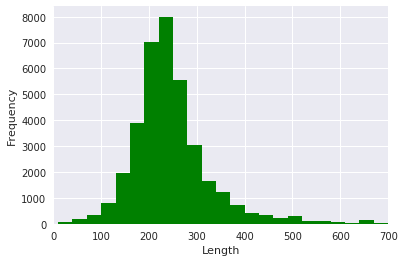

In [41]:
# distribution plot
bins = np.arange (10, churn_df['length'].max()+30, 30)
plt.hist(data = churn_df, x = 'length', bins = bins, color='g')
plt.xlim(0,700)
plt.xlabel('Length')
plt.ylabel('Frequency');

Now we can do the same process for customers who didn't churn.

In [42]:
# users who did not churn
non_churn_df = filtered_df.filter(filtered_df.Churn ==0).toPandas()

In [43]:

non_churn_df.length.dropna(inplace=True)

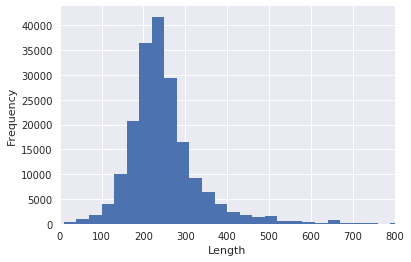

In [44]:
# plot distribution
bins = np.arange (10, non_churn_df['length'].max()+30, 30)
plt.hist(data = non_churn_df, x = 'length', bins = bins)
plt.xlim(0,800)
plt.xlabel('Length')
plt.ylabel('Frequency');

As we can see that both(churned users and non-churned users) have very similar length distributions.

###  Gender wise analysis -  Churned vs Non-Churned Users

Now we can examine if gender had an effect on users that churned vs. those that stayed.

In [45]:
# dataframe grouped by churn and gender
gender_df = filtered_df.select(['userId', 'Churn', 'gender']).dropDuplicates().groupBy('gender', 'Churn').count()

In [46]:
gender_df.collect()

[Row(gender='F', Churn=0, count=84),
 Row(gender='F', Churn=1, count=20),
 Row(gender='M', Churn=0, count=89),
 Row(gender='M', Churn=1, count=32)]

In [47]:
gender_df = gender_df.toPandas()

In [48]:
# visualisation
gender_df = gender_df.sort_values('count', ascending = False)

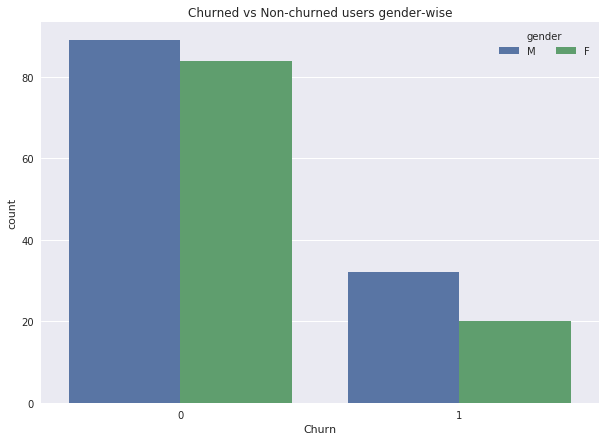

In [49]:
# barplot
plt.figure(figsize = [10,7])
ax = sns.barplot(data = gender_df, x = 'Churn', y='count', hue = 'gender', capsize=1)
ax.legend(loc = 1, ncol = 2, framealpha =1, title = 'gender')
plt.title("Churned vs Non-churned users gender-wise");

In [50]:
churned_male = gender_df.query('gender=="M" & Churn==1')['count'].values[0]
non_churned_male = gender_df.query('gender=="M" & Churn==0')['count'].values[0]

### Male churn rate

In [51]:
male_churn_rate = churned_male/(non_churned_male+churned_male)*100
male_churn_rate

26.446280991735538

### Female churn rate

In [52]:
churned_female = gender_df.query('gender=="F" & Churn==1')['count'].values[0]
non_churned_female = gender_df.query('gender=="F" & Churn==0')['count'].values[0]

In [53]:
female_churn_rate = churned_female/(non_churned_female+churned_female)*100
female_churn_rate

19.230769230769234

As we can see the male churn rate is higher than the female churn rate.

### Churned vs Non-Churned users based on plan

here we are going to analyse if subscription/free plan has an effect on whether a user will churn or not. The difference between subscription and free plan is that with subscription,the user can stream unlimited with any Ads and under free plan, the user gets Ads in between while streaming.

In [54]:
# dataframe based on choosen level
plan_df = filtered_df.select(['userId', 'Churn', 'level']).dropDuplicates().groupBy('level','Churn').count()

In [55]:
plan_df.toPandas()

,level,Churn,count
0,free,0,149
1,paid,0,129
2,free,1,46
3,paid,1,36


In [56]:
plan_df = plan_df.toPandas()

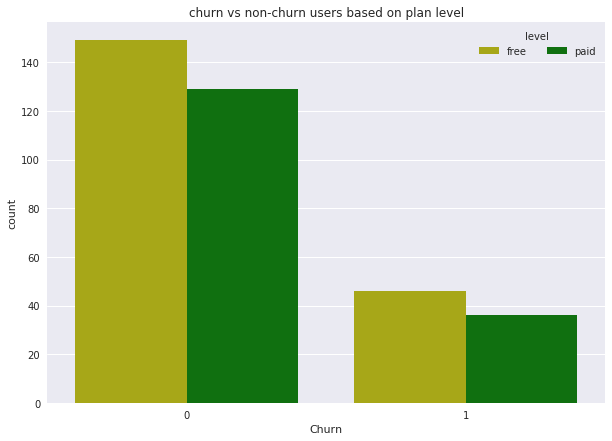

In [57]:
# barplot between churn vs non-churn users based on choosed plan
plt.figure(figsize = [10,7])
ax = sns.barplot(data = plan_df, x = 'Churn', y='count', hue = 'level', capsize=1, palette=['y','g'])
ax.legend(loc = 1, ncol = 2, framealpha =1, title = 'level')
plt.title("churn vs non-churn users based on plan level");

### Churn rate under free plan

In [58]:
churned_free = plan_df.query('level=="free" & Churn==1')['count'].values[0]
non_churned_free = plan_df.query('level=="free" & Churn==0')['count'].values[0]

In [59]:
churn_rate_free = churned_free/(churned_free+non_churned_free)*100
print(f"free plan churn rate: {churn_rate_free.round(2)} %")

free plan churn rate: 23.59 %


### Churn rate under subscription plan

In [60]:
churned_paid = plan_df.query('level=="paid" & Churn==1')['count'].values[0]
non_churned_paid = plan_df.query('level=="paid" & Churn==0')['count'].values[0]

In [61]:
churn_rate_paid = churned_paid/(churned_paid+non_churned_paid)*100
print(f"subscription churn rate: {churn_rate_paid.round(2)} %")

subscription churn rate: 21.82 %


From the above figures, we can conclude that the free plan users have more probability to churn compared to the users who have taken the paid plan. Although this the difference in churn rate between free and paid users is less(~1.5%).

### Churned vs Non-Churned users based their Page Visit

Now we gonna analyse if there is any pattern of the pages visited by the churned users and non-churned ones.

In [62]:
page_df = filtered_df.select(['userId', 'Churn', 'page']).groupBy('page','Churn').count()

In [63]:
page_df.toPandas()

,page,Churn,count
0,Settings,0,1244
1,Thumbs Down,1,496
2,Thumbs Up,1,1859
3,Add to Playlist,1,1038
4,Error,1,32
5,About,1,56
6,Thumbs Down,0,2050
7,Roll Advert,1,967
8,Home,0,8410
9,Cancellation Confirmation,1,52


In [64]:
page_df = page_df.toPandas()

In [65]:
churn_count =  page_df.query('Churn==1').sum()
non_churn_count =  page_df.query('Churn==0').sum()

In [66]:
churn_count['count']

44864

In [67]:
non_churn_count['count']

233290

In [68]:
### add a new column 'rate' which is the rate of churn/non-churn by that page 
page_df['rate'] = np.where(
                          page_df['Churn']==0, 
                          page_df['count']/non_churn_count['count'], 
                          page_df['count']/churn_count['count']
                          )

In [69]:
page_df.head(50)

,page,Churn,count,rate
0,Settings,0,1244,0.005332
1,Thumbs Down,1,496,0.011056
2,Thumbs Up,1,1859,0.041436
3,Add to Playlist,1,1038,0.023137
4,Error,1,32,0.000713
5,About,1,56,0.001248
6,Thumbs Down,0,2050,0.008787
7,Roll Advert,1,967,0.021554
8,Home,0,8410,0.036050
9,Cancellation Confirmation,1,52,0.001159


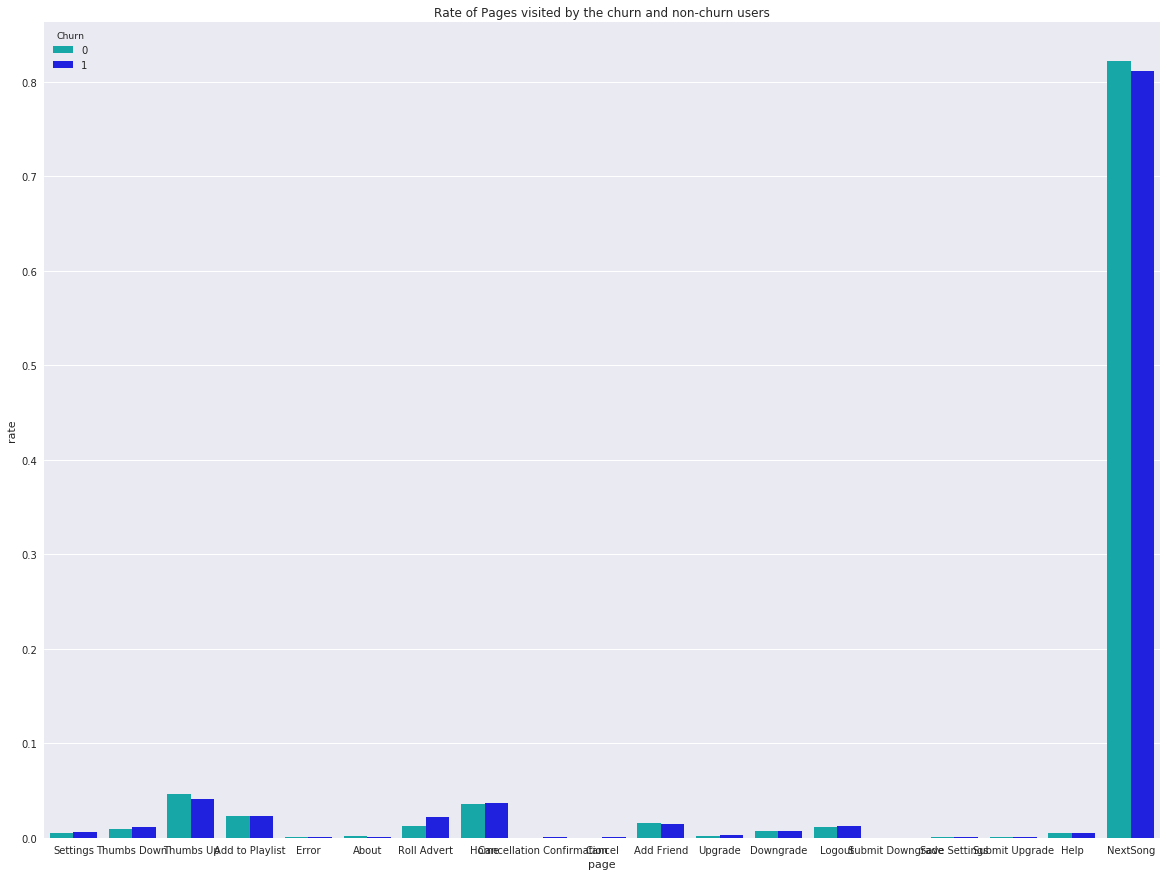

In [70]:
# pages by churn
plt.figure(figsize=[20,15])
sns.barplot(data = page_df, x = 'page', y = 'rate', hue = 'Churn', palette=['c', 'b'], capsize=2, ci=3)
plt.title('Rate of Pages visited by the churn and non-churn users');

As we see the most popular action for both users churned and non-churned was to skip to the next song. 

### Songs per Hour

Let's now see the taste and the number of songs of the users who churned vs those who did not.

In [71]:
# calculat the hours from 'timestamp'
get_hours = udf(lambda i: datetime.datetime.fromtimestamp(i / 1000.0).hour)

In [72]:
filtered_df = filtered_df.withColumn("hour", get_hours(filtered_df.ts))

In [73]:
filtered_df.head()

Row(artist=None, auth='Logged In', firstName='Darianna', gender='F', itemInSession=34, lastName='Carpenter', length=None, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', Churn=0, hour='18')

Now, we take a look at the non-churn users first.

In [74]:
non_churn_songs_hour = filtered_df.filter((filtered_df.page == "NextSong") & (filtered_df.Churn == 0)).groupby(filtered_df.hour).count().orderBy(filtered_df.hour.cast("float"))

In [75]:
non_churn_songs_hour.show(50)

+----+-----+
|hour|count|
+----+-----+
|   0| 7527|
|   1| 7035|
|   2| 7014|
|   3| 7063|
|   4| 6914|
|   5| 6960|
|   6| 6836|
|   7| 6873|
|   8| 7023|
|   9| 7268|
|  10| 7502|
|  11| 7440|
|  12| 7918|
|  13| 8073|
|  14| 8792|
|  15| 9462|
|  16| 9721|
|  17| 9464|
|  18| 9146|
|  19| 9112|
|  20| 9107|
|  21| 8853|
|  22| 8526|
|  23| 8085|
+----+-----+



In [76]:
non_churn_songs_hour = non_churn_songs_hour.toPandas()
non_churn_songs_hour.hour = pd.to_numeric(non_churn_songs_hour.hour)

In [77]:
non_churn_songs_hour

,hour,count
0,0,7527
1,1,7035
2,2,7014
3,3,7063
4,4,6914
5,5,6960
6,6,6836
7,7,6873
8,8,7023
9,9,7268


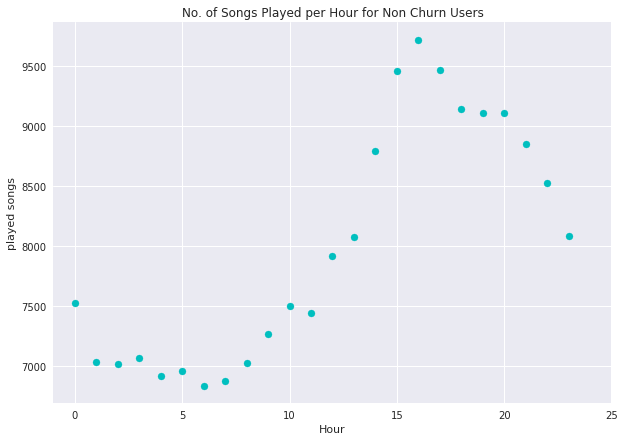

In [78]:
#plot the distribution
plt.figure(figsize = [10, 7])
plt.scatter(non_churn_songs_hour["hour"], non_churn_songs_hour["count"], c='c')
plt.xlim(-1, 25)
plt.xlabel("Hour")
plt.ylabel("played songs")
plt.title("No. of Songs Played per Hour for Non Churn Users");

From the above scatter plot, we can draw the following conclusions:
- The songs start rising right from 8-9 am in the morning, gets to the peak in between 3-6pm and starts falling from 8pm onwards and remains lowest until next morning 7am.

In [79]:
# now we do the same analysis as above for the users who churned
churn_songs_hour = filtered_df.filter((filtered_df.page == "NextSong") & (filtered_df.Churn == 1)).groupby(filtered_df.hour).count().orderBy(filtered_df.hour.cast("float"))

In [80]:
churn_songs_hour.show()

+----+-----+
|hour|count|
+----+-----+
|   0| 1535|
|   1| 1353|
|   2| 1322|
|   3| 1292|
|   4| 1233|
|   5| 1218|
|   6| 1218|
|   7| 1218|
|   8| 1230|
|   9| 1230|
|  10| 1380|
|  11| 1390|
|  12| 1408|
|  13| 1571|
|  14| 1702|
|  15| 1892|
|  16| 1915|
|  17| 1996|
|  18| 1978|
|  19| 1818|
+----+-----+
only showing top 20 rows



In [81]:
churn_songs_hour = churn_songs_hour.toPandas()
churn_songs_hour.hour = pd.to_numeric(churn_songs_hour.hour)

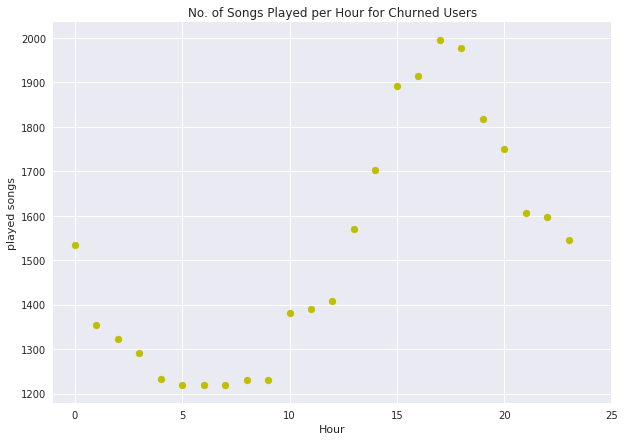

In [82]:
# songs distribution per hour for churned users
plt.figure(figsize = [10, 7])
plt.scatter(churn_songs_hour["hour"], churn_songs_hour["count"], c='y')
plt.xlim(-1, 25)
plt.xlabel("Hour")
plt.ylabel("played songs")
plt.title("No. of Songs Played per Hour for Churned Users");

The song distribution and pattern remains the same for both churned and non curn users although the no. of songs played decreases by many folds. 

### No. of Unique Artists the users listened to

In [83]:
artist_df = filtered_df.select("artist", "userId", "Churn").dropDuplicates().groupby("userId", "Churn").count()

In [84]:
artist_df.show()

+------+-----+-----+
|userId|Churn|count|
+------+-----+-----+
|100010|    0|  253|
|200002|    0|  340|
|   125|    1|    9|
|   124|    0| 2233|
|    51|    1| 1386|
|     7|    0|  143|
|    15|    0| 1303|
|    54|    1| 1745|
|   155|    0|  644|
|100014|    1|  234|
|   132|    0| 1300|
|   154|    0|   79|
|   101|    1| 1242|
|    11|    0|  535|
|   138|    0| 1333|
|300017|    0| 2071|
|100021|    1|  208|
|    29|    1| 1805|
|    69|    0|  866|
|   112|    0|  196|
+------+-----+-----+
only showing top 20 rows



In [85]:
# average
artist_df.groupby('Churn').agg({"count":"avg"}).show()

+-----+-----------------+
|Churn|       avg(count)|
+-----+-----------------+
|    0|750.7803468208092|
|    1|519.6923076923077|
+-----+-----------------+



In [86]:
artist_df = artist_df.toPandas()

In [87]:
artist_df.describe()

,Churn,count
count,225.000000,225.000000
mean,0.231111,697.373333
std,0.422483,603.956977
min,0.000000,4.000000
25%,0.000000,208.000000
50%,0.000000,556.000000
75%,0.000000,1099.000000
max,1.000000,3545.000000


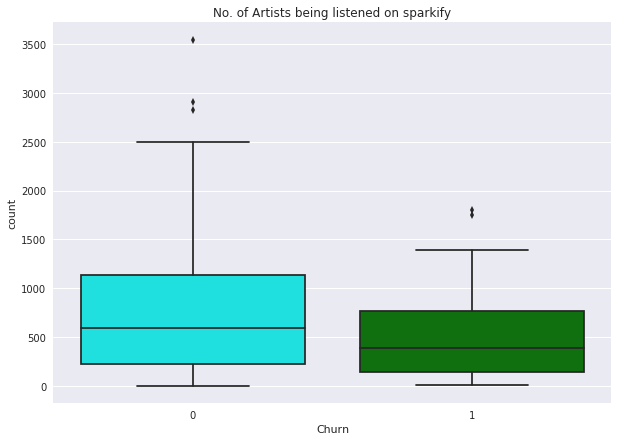

In [88]:
# plot boxplot
plt.figure(figsize = [10, 7])
ax = sns.boxplot(data = artist_df, x = 'Churn', y='count', palette=['cyan', 'green'])
plt.title("No. of Artists being listened on sparkify");

As it can be seen from the box plot, the Non-churend users have listened to a wide varity of unique artists compared to the churned users.

### Session wise songs for the Churned & Non-churned users.

In [89]:
song_df = filtered_df.filter(filtered_df.page == "NextSong").dropDuplicates().groupBy('sessionId','Churn').count()

In [90]:
song_df.groupby('Churn').agg({"count":"avg"}).show()

+-----+-----------------+
|Churn|       avg(count)|
+-----+-----------------+
|    0| 93.3369036027264|
|    1|79.81140350877193|
+-----+-----------------+



In [91]:
song_df = song_df.groupby('Churn').agg({"count":"avg"})

In [92]:
song_df = song_df.toPandas()

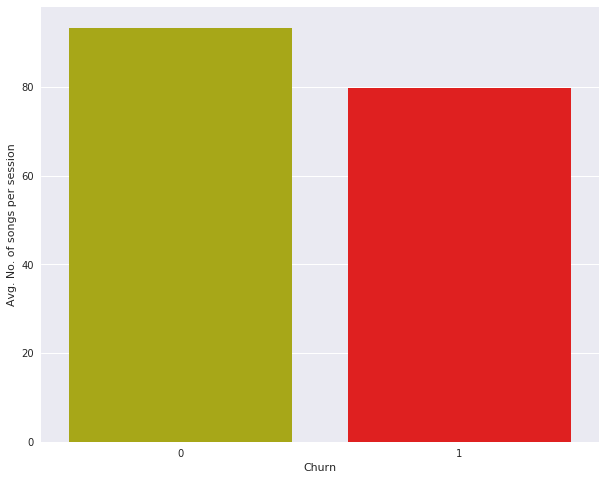

In [93]:
# plot distribution
plt.figure(figsize = [10, 8])
ax = sns.barplot(data = song_df, x = 'Churn', y='avg(count)', palette=['y', 'r'])
plt.ylabel("Avg. No. of songs per session");

### Location Impact on churn

Now let's analyze if the location play any role in terms of churning.

In [94]:
filtered_df.select("location", "userId", "Churn").groupby("location").count().show()

+--------------------+-----+
|            location|count|
+--------------------+-----+
|     Gainesville, FL| 1229|
|Atlantic City-Ham...| 2176|
|Deltona-Daytona B...|   73|
|San Diego-Carlsba...|  754|
|Cleveland-Elyria, OH| 1392|
|Kingsport-Bristol...| 1863|
|New Haven-Milford...| 4007|
|Birmingham-Hoover...|   75|
|  Corpus Christi, TX|   11|
|         Dubuque, IA|  651|
|Las Vegas-Henders...| 2042|
|Indianapolis-Carm...|  970|
|Seattle-Tacoma-Be...|  246|
|          Albany, OR|   23|
|   Winston-Salem, NC|  819|
|     Bakersfield, CA| 1775|
|Los Angeles-Long ...|30131|
|Minneapolis-St. P...| 2134|
|San Francisco-Oak...| 2647|
|Phoenix-Mesa-Scot...| 4846|
+--------------------+-----+
only showing top 20 rows



In [95]:
# get last two characters from the location column
state_code = udf(lambda x: x[-2:])

In [96]:
# add 'state' column
state_df = filtered_df.withColumn("state", state_code(filtered_df.location))

In [97]:
state_df.show()

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+----+-----+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|       page| registration|sessionId|                song|status|           ts|           userAgent|userId|Churn|hour|state|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+----+-----+
|                null|Logged In| Darianna|     F|           34|Carpenter|     null| free|Bridgeport-Stamfo...|   PUT|     Logout|1538016340000|      187|                null|   307|1542823952000|"Mozilla/5.0 (iPh...|100010|    0|  18|   CT|
|          Lily Allen|Logged In| Dar

In [98]:
state_df = state_df.select("state", "userId", "Churn").dropDuplicates().groupby("state", "Churn").count()

In [99]:
state_df = state_df.toPandas()
state_df

,state,Churn,count
0,AL,0,4
1,IL,0,8
2,AZ,1,2
3,OH,0,1
4,AL,1,2
5,PA,0,13
6,NV,0,3
7,PA,1,5
8,OH,1,2
9,UT,0,1


Text(0.5,1,'count of churned and non-churned Users ')

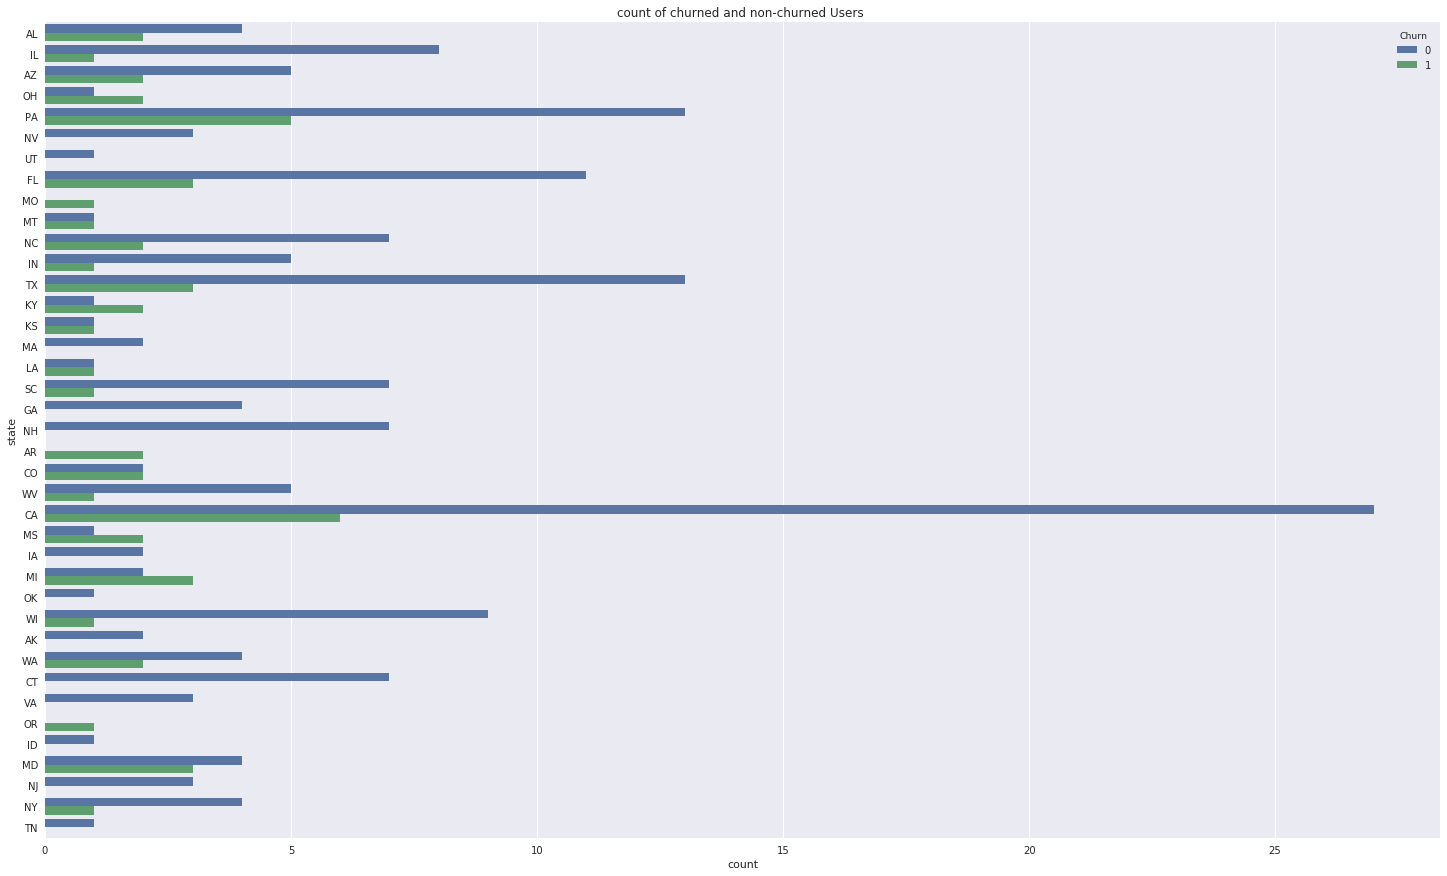

In [100]:
# distribution plot 
plt.figure(figsize=[25,15])
sns.barplot(data = state_df, x = 'count', y = 'state', hue = 'Churn')
plt.title('count of churned and non-churned Users ')

As we see the most number of users comes from CA, TX, FL PA states.Although this does not give any useful information about churning.

### Impact of old vs new user on churn

Now, let's examin how the user's stay duration on the sparkify platform impacts the churn.

In [101]:
duration_df = filtered_df.select(['userId', 'registration', 'ts', 'Churn']).dropDuplicates().sort('userId')

In [102]:
w = Window.partitionBy("userId").orderBy(desc("ts"))

In [103]:
# rank with the most recent timestamp as rank 1
duration_df = duration_df.withColumn("Rank", dense_rank().over(w))

In [104]:
duration_df.show()

+------+-------------+-------------+-----+----+
|userId| registration|           ts|Churn|Rank|
+------+-------------+-------------+-----+----+
|    10|1538159495000|1542631788000|    0|   1|
|    10|1538159495000|1542631753000|    0|   2|
|    10|1538159495000|1542631690000|    0|   3|
|    10|1538159495000|1542631518000|    0|   4|
|    10|1538159495000|1542631517000|    0|   5|
|    10|1538159495000|1542631090000|    0|   6|
|    10|1538159495000|1542630866000|    0|   7|
|    10|1538159495000|1542630637000|    0|   8|
|    10|1538159495000|1542630407000|    0|   9|
|    10|1538159495000|1542630394000|    0|  10|
|    10|1538159495000|1542630248000|    0|  11|
|    10|1538159495000|1542630247000|    0|  12|
|    10|1538159495000|1542630029000|    0|  13|
|    10|1538159495000|1542629861000|    0|  14|
|    10|1538159495000|1542629636000|    0|  15|
|    10|1538159495000|1542629464000|    0|  16|
|    10|1538159495000|1542629238000|    0|  17|
|    10|1538159495000|1542629029000|    

In [105]:
# users with a rank of 1 i.e the very first row
duration_df = duration_df.filter(duration_df.Rank == 1).drop(duration_df.Rank)

In [106]:
duration_df.show()

+------+-------------+-------------+-----+
|userId| registration|           ts|Churn|
+------+-------------+-------------+-----+
|    10|1538159495000|1542631788000|    0|
|   100|1537982255000|1543587349000|    0|
|100001|1534627466000|1538498205000|    1|
|100002|1529934689000|1543799476000|    0|
|100003|1537309344000|1539274781000|    1|
|100004|1528560242000|1543459065000|    0|
|100005|1532610926000|1539971825000|    1|
|100006|1537964483000|1538753070000|    1|
|100007|1533522419000|1543491909000|    1|
|100008|1537440271000|1543335219000|    0|
|100009|1537376437000|1540611104000|    1|
|100010|1538016340000|1542823952000|    0|
|100011|1537970819000|1538417085000|    1|
|100012|1537381154000|1541100900000|    1|
|100013|1537367773000|1541184816000|    1|
|100014|1535389443000|1542740649000|    1|
|100015|1537208989000|1543073753000|    1|
|100016|1536854322000|1543335647000|    0|
|100017|1533247234000|1540062847000|    1|
|100018|1533812833000|1543378360000|    0|
+------+---

In [107]:
# subtract the registration from ts 
duration_df = duration_df.withColumn("delta_days", (duration_df['ts']) - (duration_df['registration']))

In [108]:
duration_df.show()

+------+-------------+-------------+-----+-----------+
|userId| registration|           ts|Churn| delta_days|
+------+-------------+-------------+-----+-----------+
|    10|1538159495000|1542631788000|    0| 4472293000|
|   100|1537982255000|1543587349000|    0| 5605094000|
|100001|1534627466000|1538498205000|    1| 3870739000|
|100002|1529934689000|1543799476000|    0|13864787000|
|100003|1537309344000|1539274781000|    1| 1965437000|
|100004|1528560242000|1543459065000|    0|14898823000|
|100005|1532610926000|1539971825000|    1| 7360899000|
|100006|1537964483000|1538753070000|    1|  788587000|
|100007|1533522419000|1543491909000|    1| 9969490000|
|100008|1537440271000|1543335219000|    0| 5894948000|
|100009|1537376437000|1540611104000|    1| 3234667000|
|100010|1538016340000|1542823952000|    0| 4807612000|
|100011|1537970819000|1538417085000|    1|  446266000|
|100012|1537381154000|1541100900000|    1| 3719746000|
|100013|1537367773000|1541184816000|    1| 3817043000|
|100014|15

In [109]:
duration_df = duration_df.withColumn('days',(duration_df['delta_days']/1000/3600/24))

In [110]:
duration_df.show()

+------+-------------+-------------+-----+-----------+------------------+
|userId| registration|           ts|Churn| delta_days|              days|
+------+-------------+-------------+-----+-----------+------------------+
|    10|1538159495000|1542631788000|    0| 4472293000| 51.76265046296297|
|   100|1537982255000|1543587349000|    0| 5605094000| 64.87377314814815|
|100001|1534627466000|1538498205000|    1| 3870739000| 44.80021990740741|
|100002|1529934689000|1543799476000|    0|13864787000|160.47207175925925|
|100003|1537309344000|1539274781000|    1| 1965437000|22.748113425925926|
|100004|1528560242000|1543459065000|    0|14898823000|172.44008101851853|
|100005|1532610926000|1539971825000|    1| 7360899000| 85.19559027777778|
|100006|1537964483000|1538753070000|    1|  788587000| 9.127164351851851|
|100007|1533522419000|1543491909000|    1| 9969490000|115.38761574074074|
|100008|1537440271000|1543335219000|    0| 5894948000| 68.22856481481482|
|100009|1537376437000|1540611104000|  

In [111]:
duration_df = duration_df.toPandas()

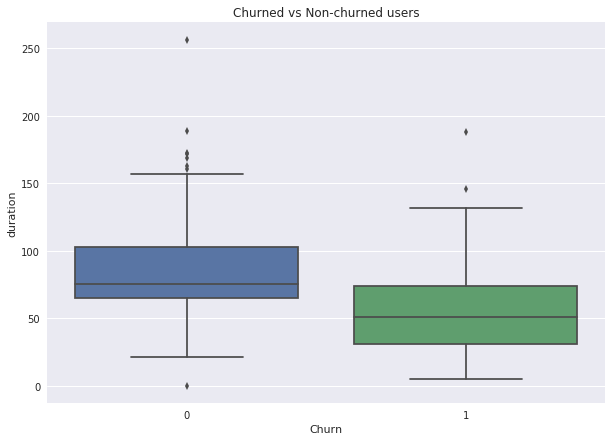

In [112]:
# plot distribution
plt.figure(figsize=[10, 7])
sns.boxplot(data = duration_df, x = 'Churn', y ='days')
plt.title('Churned vs Non-churned users')
plt.ylabel("duration");

The users who has been using platform and services for long time mostly stays longer and are less likely to churn while the users who churn are mostly those stays on the platform for a short duration.

### Effect of  OS & Browser on Churn

Let's now try to understand and see if the operating system and the browser the user is using has any impact on churning. The information about the OS and  browsers can be found in the column 'userAgent'.

In [113]:
OS_df = filtered_df.select("userId", "userAgent", "Churn").dropDuplicates(['userId'])

In [114]:
OS_df.show()

+------+--------------------+-----+
|userId|           userAgent|Churn|
+------+--------------------+-----+
|100010|"Mozilla/5.0 (iPh...|    0|
|200002|"Mozilla/5.0 (iPh...|    0|
|   125|"Mozilla/5.0 (Mac...|    1|
|   124|"Mozilla/5.0 (Mac...|    0|
|    51|"Mozilla/5.0 (Win...|    1|
|     7|Mozilla/5.0 (Wind...|    0|
|    15|"Mozilla/5.0 (Win...|    0|
|    54|Mozilla/5.0 (Wind...|    1|
|   155|"Mozilla/5.0 (Win...|    0|
|100014|"Mozilla/5.0 (Win...|    1|
|   132|"Mozilla/5.0 (Mac...|    0|
|   154|"Mozilla/5.0 (Win...|    0|
|   101|Mozilla/5.0 (Wind...|    1|
|    11|Mozilla/5.0 (Wind...|    0|
|   138|"Mozilla/5.0 (iPa...|    0|
|300017|"Mozilla/5.0 (Mac...|    0|
|100021|"Mozilla/5.0 (Mac...|    1|
|    29|"Mozilla/5.0 (Mac...|    1|
|    69|"Mozilla/5.0 (Win...|    0|
|   112|Mozilla/5.0 (Wind...|    0|
+------+--------------------+-----+
only showing top 20 rows



In [115]:
OS_df = OS_df.toPandas()

In [116]:
OS_df

,userId,userAgent,Churn
0,100010,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",0
1,200002,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1 like M...",0
2,125,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",1
3,124,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",0
4,51,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",1
5,7,Mozilla/5.0 (Windows NT 6.1; rv:31.0) Gecko/20...,0
6,15,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",0
7,54,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,1
8,155,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",0
9,100014,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",1


In [117]:
# unique value or the unique combination of OS and browser
OS_df.userAgent.nunique()

56

In [118]:
# possible list of operating systems
OS_df.userAgent.value_counts()

"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"                                24
Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0                                                                       18
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"                     16
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4"                        12
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"                     12
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.78.2 (KHTML, like Gecko) Version/7.0.6 Safari/537.78.2"                        10
"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"             

In [119]:
# list of operating systems
os_list = ["Windows", "Linux", "Mac", "iPhone", "iPad"]

In [120]:
# create an 'OS' column 
OS_df['OS'] = OS_df.userAgent.str.extract(f'(?i)({"|".join(os_list)})')

In [121]:
OS_df

,userId,userAgent,Churn,OS
0,100010,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",0,iPhone
1,200002,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1 like M...",0,iPhone
2,125,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",1,Mac
3,124,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",0,Mac
4,51,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",1,Windows
5,7,Mozilla/5.0 (Windows NT 6.1; rv:31.0) Gecko/20...,0,Windows
6,15,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",0,Windows
7,54,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,1,Windows
8,155,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",0,Windows
9,100014,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",1,Windows


In [122]:
OS_df['OS'].value_counts()

Windows    111
Mac         86
iPhone      13
Linux       12
iPad         3
Name: OS, dtype: int64

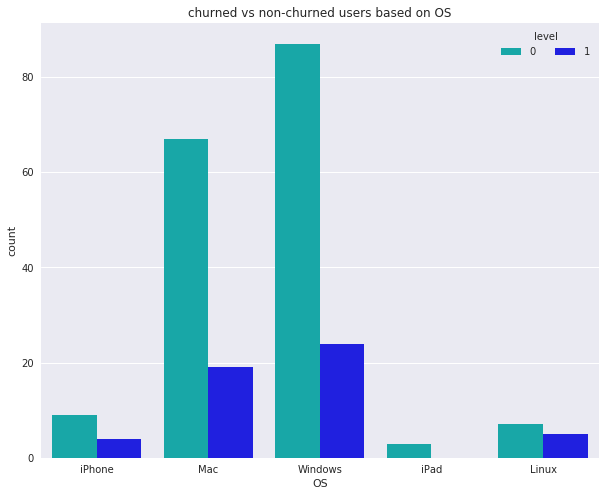

In [123]:
# plot count for churn and non churn users
plt.figure(figsize=[10,8])
sns.countplot(data = OS_df, x = 'OS', hue ='Churn', palette=['c', 'b'])
plt.title('churned vs non-churned users based on OS')
plt.legend(loc = 1, ncol = 2, framealpha =1, title = 'level');

This might not be effective in terms of making any impact on churn but as we can see the most users is on Windows and least uses iPad.

Like OS, we can also check for the browser's impact on the churn if any.

In [124]:
browser_list = ["Chrome", "Firefox", "Safari", "Trident"]

In [125]:
OS_df['browser'] = OS_df.userAgent.str.extract(f'(?i)({"|".join(browser_list)})')

In [126]:
OS_df['browser'].value_counts()

Chrome     117
Firefox     50
Safari      46
Trident     12
Name: browser, dtype: int64

Trident is an Internet Explorer software.So change it to 'Internet Explorer'.

In [127]:
OS_df['browser'].replace({"Trident":"Internet Explorer"}, inplace = True)

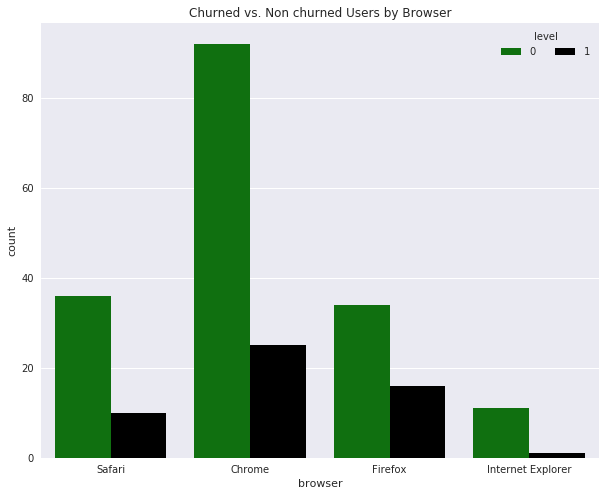

In [128]:
plt.figure(figsize=[10,8])
sns.countplot(data = OS_df, x = 'browser', hue ='Churn', palette=['g', 'k'])
plt.title('Churned vs. Non churned Users by Browser')
plt.legend(loc = 1, ncol = 2, framealpha =1, title = 'level');

few points can be drawn from the above chart such as, chrome is widely the most popular and used browser. Internet Explorer is least used browser and firefox is the browser with highest churning rate. Although it's not very clear about its impact on the churn overall . So this won't be coonsidered for modelling.

# Feature Engineering
<a class="anchor" id="eng"></a>

Now that we have completed the EDA esction, we can build on top of those features that seem the most effective to train our model for best results.

The features we'll work on building out are:
- Categorical:
 - gender
 - level

- Numerical:
 - number of songs per session
 - number of rollads action
 - number of thumbs-down action
 - number of thumbs-up action
 - number of friends that have been added
 - number of songs added to the playlist
 - number of different artists listened to on Sparkify
 - number of days on the app
 
We then add a churn label and join these all together to create the final dataframe with each row representing all the information regarding every individual.

Let's work on the categorical features first and convert them into numeric variables.

### Gender

Assign a 1 for 'female' and a 0 for 'male'.

In [129]:
df1_gender = filtered_df.select(['userId', 'gender']).dropDuplicates()

In [130]:
# add a gender column 
df1_gender = df1_gender.withColumn('gender', when(col('gender') == 'F', 1).otherwise(0))

In [131]:
df1_gender.count()

225

In [132]:
df1_gender.show()

+------+------+
|userId|gender|
+------+------+
|    44|     1|
|    46|     1|
|    41|     1|
|    72|     1|
|300023|     1|
|    39|     1|
|100010|     1|
|    40|     1|
|    94|     1|
|    35|     1|
|    75|     1|
|   116|     1|
|200001|     0|
|200020|     0|
|100008|     1|
|200015|     0|
|   100|     0|
|100006|     1|
|300005|     1|
|    25|     1|
+------+------+
only showing top 20 rows



In [133]:
df1_gender.describe()

DataFrame[summary: string, userId: string, gender: string]

### Level

the level column has 2 values either paid or free and level can change. therefore we'll only consider the most recent one.

In [134]:
df2_level = filtered_df.select(['userId', 'level', 'ts']).dropDuplicates().sort('userId')

In [135]:
w = Window.partitionBy("userId").orderBy(desc("ts"))

In [136]:
df2_level = df2_level.withColumn("Rank", dense_rank().over(w))

In [137]:
df2_level.show()

+------+-----+-------------+----+
|userId|level|           ts|Rank|
+------+-----+-------------+----+
|    10| paid|1542631788000|   1|
|    10| paid|1542631753000|   2|
|    10| paid|1542631690000|   3|
|    10| paid|1542631518000|   4|
|    10| paid|1542631517000|   5|
|    10| paid|1542631090000|   6|
|    10| paid|1542630866000|   7|
|    10| paid|1542630637000|   8|
|    10| paid|1542630407000|   9|
|    10| paid|1542630394000|  10|
|    10| paid|1542630248000|  11|
|    10| paid|1542630247000|  12|
|    10| paid|1542630029000|  13|
|    10| paid|1542629861000|  14|
|    10| paid|1542629636000|  15|
|    10| paid|1542629464000|  16|
|    10| paid|1542629238000|  17|
|    10| paid|1542629029000|  18|
|    10| paid|1542629028000|  19|
|    10| paid|1542628798000|  20|
+------+-----+-------------+----+
only showing top 20 rows



In [138]:
df2_level = df2_level.filter(df2_level.Rank == 1).drop(df2_level.Rank)

In [139]:
df2_level = df2_level.drop('ts')

In [140]:
df2_level = df2_level.withColumn('level', when(col('level') == 'paid', 1).otherwise(0))

In [141]:
df2_level.count()

225

In [142]:
df2_level.show()

+------+-----+
|userId|level|
+------+-----+
|    10|    1|
|   100|    1|
|100001|    0|
|100002|    1|
|100003|    0|
|100004|    1|
|100005|    0|
|100006|    0|
|100007|    1|
|100008|    0|
|100009|    0|
|100010|    0|
|100011|    0|
|100012|    0|
|100013|    1|
|100014|    1|
|100015|    1|
|100016|    0|
|100017|    0|
|100018|    0|
+------+-----+
only showing top 20 rows



In [143]:

df2_level.toPandas()

,userId,level
0,10,1
1,100,1
2,100001,0
3,100002,1
4,100003,0
5,100004,1
6,100005,0
7,100006,0
8,100007,1
9,100008,0


### Avg. Number of songs per session

In [144]:
df3_song = filtered_df.filter(filtered_df.page == "NextSong").groupBy('userId','sessionId').count()

In [145]:
filtered_df.filter(filtered_df.page == "NextSong").groupBy('userId','sessionId').count().show(
)

+------+---------+-----+
|userId|sessionId|count|
+------+---------+-----+
|    92|      358|   57|
|    42|      433|   16|
|   101|      635|  708|
|   120|      627|  236|
|   140|      798|    3|
|   122|      691|    6|
|    29|     1030|   13|
|     8|     1200|   11|
|    96|     1653|  133|
|   153|     1794|   62|
|    97|     2019|   70|
|    35|     2270|   10|
|   110|     1776|   18|
|300011|       60|   27|
|   137|      136|    6|
|    40|      484|   61|
|    35|      544|   13|
|    24|      620|    5|
|    47|       46|    3|
|    85|     1098|   73|
+------+---------+-----+
only showing top 20 rows



In [146]:
df3_song = df3_song.groupby('userId').agg({"count":"avg"})

In [147]:
df3_song = df3_song.withColumnRenamed("avg(count)", "avg_song")

In [148]:
df3_song.count()

225

In [149]:
df3_song.show()

+------+------------------+
|userId|          avg_song|
+------+------------------+
|100010|39.285714285714285|
|200002|              64.5|
|   125|               8.0|
|    51|             211.1|
|   124|145.67857142857142|
|     7|21.428571428571427|
|    54| 81.17142857142858|
|    15|136.71428571428572|
|   155|136.66666666666666|
|100014|42.833333333333336|
|   132|             120.5|
|   154|              28.0|
|   101|             179.7|
|    11|           40.4375|
|300017|59.540983606557376|
|   138|             138.0|
|    29| 89.05882352941177|
|    69|             125.0|
|100021|              46.0|
|    42| 87.14634146341463|
+------+------------------+
only showing top 20 rows



### Number of rollads action


higher number of roll-ad count for churned users since free users are shown ads whereas paid subscribers aren't shown ads.

In [150]:
df4_rollad = filtered_df.select(["userId", "page"])

In [151]:
rollad_func = udf(lambda x: 1 if x == "Roll Advert" else 0, IntegerType())

In [152]:
# add a rollad column
df4_rollad = df4_rollad.withColumn("rollad", rollad_func("page"))

In [153]:
df4_rollad = df4_rollad.groupby('userId').sum("rollad")

In [154]:
df4_rollad = df4_rollad.withColumnRenamed("sum(rollad)", "roll-ad")

In [155]:
df4_rollad.count()

225

In [156]:
df4_rollad.show()

+------+-------+
|userId|roll-ad|
+------+-------+
|100010|     52|
|200002|      7|
|   125|      1|
|    51|      0|
|   124|      4|
|     7|     16|
|    54|     47|
|    15|      1|
|   155|      8|
|   132|      2|
|   154|     10|
|100014|      2|
|   101|      8|
|    11|     39|
|   138|     17|
|300017|     11|
|    29|     22|
|    69|      3|
|100021|     30|
|    42|     10|
+------+-------+
only showing top 20 rows



### Number of thumbs-down action


It's pretty obvious that those users who churned in the past had performed more thumbs down actions compared to those who stayed with the service. 

In [157]:
df5_thumbsdown = filtered_df.select(["userId", "page"])

In [158]:
thumdsdown_func = udf(lambda x: 1 if x == "Thumbs Down" else 0, IntegerType())

In [159]:
df5_thumbsdown = df5_thumbsdown.withColumn("Thumbs Down", thumdsdown_func("page"))

In [160]:
df5_thumbsdown = df5_thumbsdown.groupby('userId').sum("Thumbs Down")

In [161]:
df5_thumbsdown = df5_thumbsdown.withColumnRenamed("sum(Thumbs Down)", "thumbs_down")

In [162]:
df5_thumbsdown.count()

225

In [163]:
df5_thumbsdown.show()

+------+-----------+
|userId|thumbs_down|
+------+-----------+
|100010|          5|
|200002|          6|
|   125|          0|
|    51|         21|
|   124|         41|
|     7|          1|
|    54|         29|
|    15|         14|
|   155|          3|
|   132|         17|
|   154|          0|
|100014|          3|
|   101|         16|
|    11|          9|
|   138|         24|
|300017|         28|
|    29|         22|
|    69|          9|
|100021|          5|
|    42|         25|
+------+-----------+
only showing top 20 rows



### Number of thumbs-up action


More thumbs-up leads to longer stay and non-churn, similarly less thumbs-up leads to more churn.

In [164]:
df6_thumbsup = filtered_df.select(["userId", "page"])

In [165]:
thumbsup_func = udf(lambda x: 1 if x == "Thumbs Up" else 0, IntegerType())

In [166]:
df6_thumbsup = df6_thumbsup.withColumn("Thumbs Up", thumbsup_func("page"))

In [167]:
df6_thumbsup = df6_thumbsup.groupby('userId').sum("Thumbs Up")

In [168]:
df6_thumbsup = df6_thumbsup.withColumnRenamed("sum(Thumbs Up)", "thumbs_up")

In [169]:
df6_thumbsup.count()

225

In [170]:
df6_thumbsup.show()

+------+---------+
|userId|thumbs_up|
+------+---------+
|100010|       17|
|200002|       21|
|   125|        0|
|    51|      100|
|   124|      171|
|     7|        7|
|    54|      163|
|    15|       81|
|   155|       58|
|   132|       96|
|   154|       11|
|100014|       17|
|   101|       86|
|    11|       40|
|   138|       95|
|300017|      303|
|    29|      154|
|    69|       72|
|100021|       11|
|    42|      166|
+------+---------+
only showing top 20 rows



### Number of friends that have been added


If a user is about to churn, that user will unlikely to add or have more friends in its list and vice-versa.

In [171]:
df7_friend = filtered_df.select(["userId", "page"])

In [172]:
add_friends = udf(lambda x: 1 if x == "Add Friend" else 0, IntegerType())

In [173]:
df7_friend = df7_friend.withColumn("add_friend", add_friends("page"))

In [174]:
df7_friend = df7_friend.groupby('userId').sum("add_friend")

In [175]:
df7_friend = df7_friend.withColumnRenamed("sum(add_friend)", "add_friend")

In [176]:
df7_friend.count()

225

In [177]:
df7_friend.show()

+------+----------+
|userId|add_friend|
+------+----------+
|100010|         4|
|200002|         4|
|   125|         0|
|    51|        28|
|   124|        74|
|     7|         1|
|    54|        33|
|    15|        31|
|   155|        11|
|   132|        41|
|   154|         3|
|100014|         6|
|   101|        29|
|    11|         6|
|   138|        41|
|300017|        63|
|    29|        47|
|    69|        12|
|100021|         7|
|    42|        52|
+------+----------+
only showing top 20 rows



### Number of songs added to playlist

If a user likes the platform and services provided, he/she will more likely add more songs to the playlist and less likely to churn and vice-versa.

In [178]:
df8_playlist = filtered_df.select(["userId", "page"])

In [179]:
add_playlist = udf(lambda p: 1 if p == "Add to Playlist" else 0, IntegerType())

In [180]:
df8_playlist = df8_playlist.withColumn("Playlist", add_playlist("page"))

In [181]:
df8_playlist = df8_playlist.groupby('userId').sum("Playlist")

In [182]:
df8_playlist = df8_playlist.withColumnRenamed("sum(Playlist)", "playlist")

In [183]:
df8_playlist.count()

225

In [184]:
df8_playlist.show()

+------+--------+
|userId|playlist|
+------+--------+
|100010|       7|
|200002|       8|
|   125|       0|
|    51|      52|
|   124|     118|
|     7|       5|
|    54|      72|
|    15|      59|
|   155|      24|
|   132|      38|
|   154|       1|
|100014|       7|
|   101|      61|
|    11|      20|
|   138|      67|
|300017|     113|
|    29|      89|
|    69|      33|
|100021|       7|
|    42|     104|
+------+--------+
only showing top 20 rows



### Number of different Artists Listened to on Sparkify

The users who have explored diverse artist are more likely to stay longer. thus less likely to churn.

In [185]:
df9_artist = filtered_df.select("userId", "artist").dropDuplicates().groupby("userId").count()

In [186]:
df9_artist = df9_artist.withColumnRenamed("count", "num_artist")

In [187]:
df9_artist.count()

225

In [188]:
df9_artist.show()

+------+----------+
|userId|num_artist|
+------+----------+
|100010|       253|
|200002|       340|
|   125|         9|
|    51|      1386|
|   124|      2233|
|     7|       143|
|    15|      1303|
|    54|      1745|
|   155|       644|
|   132|      1300|
|   154|        79|
|100014|       234|
|   101|      1242|
|    11|       535|
|   138|      1333|
|300017|      2071|
|    29|      1805|
|    69|       866|
|100021|       208|
|    42|      2074|
+------+----------+
only showing top 20 rows



### number of days on the app

As we have seen in the EDA, old users are more likely to stay while the churned users are mostly those who have spent less days on the platform. 

In [189]:
duration_df.head()

,userId,registration,ts,Churn,delta_days,days
0,10,1538159495000,1542631788000,0,4472293000,51.762650
1,100,1537982255000,1543587349000,0,5605094000,64.873773
2,100001,1534627466000,1538498205000,1,3870739000,44.800220
3,100002,1529934689000,1543799476000,0,13864787000,160.472072
4,100003,1537309344000,1539274781000,1,1965437000,22.748113


In [190]:
df10_duration = duration_df[["userId", "days"]]
df10_duration = spark.createDataFrame(df10_duration)

In [191]:
df10_duration.count()

225

### Label or the target feature

Here, we add the target label column for indicating if the users has churned or not. And the value under this column will be 1 for churn and 0 for non-churn.

In [192]:
label = filtered_df.select("userId", "Churn").dropDuplicates().groupby("userId", "Churn").count()

In [193]:
# drop the count column
label = label.drop('count')

In [194]:
label.count()

225

In [195]:
# rename the churn to label
label = label.withColumnRenamed("Churn", "label")

In [196]:
label.show()

+------+-----+
|userId|label|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
|     7|    0|
|    15|    0|
|    54|    1|
|   155|    0|
|100014|    1|
|   132|    0|
|   154|    0|
|   101|    1|
|    11|    0|
|   138|    0|
|300017|    0|
|100021|    1|
|    29|    1|
|    69|    0|
|   112|    0|
+------+-----+
only showing top 20 rows



### Create the Features Dataset

We now join all the derived features together with `userId`.

In [197]:
feature_df = df1_gender.join(df2_level, ["userId"]).join(df3_song, ["userId"]).join(df4_rollad, ["userId"]).join(df5_thumbsdown, ["userId"]).join(df6_thumbsup, ["userId"]).join(df7_friend, ["userId"]).join(df8_playlist, ["userId"]).join(df9_artist, ["userId"]).join(df10_duration, ["userId"]).join(label, ["userId"])

In [198]:
feature_df.show()

+------+------+-----+------------------+-------+-----------+---------+----------+--------+----------+------------------+-----+
|userId|gender|level|          avg_song|roll-ad|thumbs_down|thumbs_up|add_friend|playlist|num_artist|              days|label|
+------+------+-----+------------------+-------+-----------+---------+----------+--------+----------+------------------+-----+
|100010|     1|    0|39.285714285714285|     52|          5|       17|         4|       7|       253|  55.6436574074074|    0|
|200002|     0|    1|              64.5|      7|          6|       21|         4|       8|       340| 70.07462962962963|    0|
|   125|     0|    0|               8.0|      1|          0|        0|         0|       0|         9| 71.31688657407408|    1|
|   124|     1|    1|145.67857142857142|      4|         41|      171|        74|     118|      2233|131.55591435185184|    0|
|    51|     0|    1|             211.1|      0|         21|      100|        28|      52|      1386|19.4558449

In [199]:
feature_df = feature_df.drop('userId')

In [200]:
feature_df.show()

+------+-----+------------------+-------+-----------+---------+----------+--------+----------+------------------+-----+
|gender|level|          avg_song|roll-ad|thumbs_down|thumbs_up|add_friend|playlist|num_artist|              days|label|
+------+-----+------------------+-------+-----------+---------+----------+--------+----------+------------------+-----+
|     1|    0|39.285714285714285|     52|          5|       17|         4|       7|       253|  55.6436574074074|    0|
|     0|    1|              64.5|      7|          6|       21|         4|       8|       340| 70.07462962962963|    0|
|     0|    0|               8.0|      1|          0|        0|         0|       0|         9| 71.31688657407408|    1|
|     1|    1|145.67857142857142|      4|         41|      171|        74|     118|      2233|131.55591435185184|    0|
|     0|    1|             211.1|      0|         21|      100|        28|      52|      1386|19.455844907407407|    1|
|     0|    0|21.428571428571427|     16

## Preprocessing

finally we have out dataframe with all the features. Before we feed this to our model, we need to do some preprocessing on top of this.

In [201]:
feature_df.printSchema()

root
 |-- gender: integer (nullable = false)
 |-- level: integer (nullable = false)
 |-- avg_song: double (nullable = true)
 |-- roll-ad: long (nullable = true)
 |-- thumbs_down: long (nullable = true)
 |-- thumbs_up: long (nullable = true)
 |-- add_friend: long (nullable = true)
 |-- playlist: long (nullable = true)
 |-- num_artist: long (nullable = false)
 |-- days: double (nullable = true)
 |-- label: long (nullable = true)



convert these columns into the numerical datatype for the model: integer and float.

In [202]:
for f_col in feature_df.columns:
    feature_df = feature_df.withColumn(f_col, feature_df[f_col].cast('float'))

In [203]:
feature_df.printSchema()

root
 |-- gender: float (nullable = false)
 |-- level: float (nullable = false)
 |-- avg_song: float (nullable = true)
 |-- roll-ad: float (nullable = true)
 |-- thumbs_down: float (nullable = true)
 |-- thumbs_up: float (nullable = true)
 |-- add_friend: float (nullable = true)
 |-- playlist: float (nullable = true)
 |-- num_artist: float (nullable = false)
 |-- days: float (nullable = true)
 |-- label: float (nullable = true)



Next, we vectorise the features.

### Vector Assembler

vector assembler tranforms the features into a vector. This vector is standardised and can then be used for the seleted algorithms.

In [204]:
v_assembler = VectorAssembler(inputCols = ["gender", "level", "avg_song", "roll-ad", "thumbs_down", "thumbs_up", "add_friend", "playlist", "num_artist", "days"], outputCol = "vec_features")

In [205]:
feature_df = v_assembler.transform(feature_df)

In [206]:
feature_df.show()

+------+-----+---------+-------+-----------+---------+----------+--------+----------+----------+-----+--------------------+
|gender|level| avg_song|roll-ad|thumbs_down|thumbs_up|add_friend|playlist|num_artist|      days|label|        vec_features|
+------+-----+---------+-------+-----------+---------+----------+--------+----------+----------+-----+--------------------+
|   1.0|  0.0|39.285713|   52.0|        5.0|     17.0|       4.0|     7.0|     253.0| 55.643658|  0.0|[1.0,0.0,39.28571...|
|   0.0|  1.0|     64.5|    7.0|        6.0|     21.0|       4.0|     8.0|     340.0|  70.07463|  0.0|[0.0,1.0,64.5,7.0...|
|   0.0|  0.0|      8.0|    1.0|        0.0|      0.0|       0.0|     0.0|       9.0|  71.31689|  1.0|(10,[2,3,8,9],[8....|
|   1.0|  1.0|145.67857|    4.0|       41.0|    171.0|      74.0|   118.0|    2233.0| 131.55591|  0.0|[1.0,1.0,145.6785...|
|   0.0|  1.0|    211.1|    0.0|       21.0|    100.0|      28.0|    52.0|    1386.0| 19.455845|  1.0|[0.0,1.0,211.1000...|
|   0.0|

### Standardization

Standardization is performed to prevent features with wider ranges from dominating the distance metric and values are shifted and rescaled so that they end up ranging between 0 and 1.

In [207]:
stand_scaler = StandardScaler(inputCol="vec_features", outputCol="features", withStd=True)

In [208]:
scaler_model = stand_scaler.fit(feature_df)

In [209]:
feature_df = scaler_model.transform(feature_df)

In [210]:
feature_df.head()

Row(gender=1.0, level=0.0, avg_song=39.28571319580078, roll-ad=52.0, thumbs_down=5.0, thumbs_up=17.0, add_friend=4.0, playlist=7.0, num_artist=253.0, days=55.64365768432617, label=0.0, vec_features=DenseVector([1.0, 0.0, 39.2857, 52.0, 5.0, 17.0, 4.0, 7.0, 253.0, 55.6437]), features=DenseVector([2.0013, 0.0, 0.9219, 2.413, 0.3823, 0.2596, 0.1943, 0.214, 0.4189, 1.4775]))

## Split the dataset into  Train, Test, Validation

In [216]:
feature_df.groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  1.0|   52|
|  0.0|  173|
+-----+-----+



As per the standard ratio, we use a 60:20:20 split.

In [217]:
train, test, valid = feature_df.randomSplit([0.6, 0.2, 0.2], seed = 90)
print(f"training dataset: {train.count()}")
print(f"test dataset: {test.count()}")
print(f"validation dataset: {valid.count()}")

training dataset: 130
test dataset: 47
validation dataset: 48


# Modeling
<a class="anchor" id="model"></a>

After creating feature dataFrame and splitting the dataset into train, test, and validation sets. We will now apply different machine learning classification algorithms which are as below:
 - Logistic Regression
 - Random Forest Classifier
 - Gradient-Boosted tree Classifier
 - Linear SVM classifier
 - Naive Bayes classifier
 

### Metrics
We will evaluate the accuracy of the various models, tuning parameters as necessary. We will finally determine the vest model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, we will use F1 score as the metric to optimize. F1 is a measure of the model's accuracy on a dataset and is used to evaluate binary classification systems.

We can start modeling .For the model with the best F-1 score, accuracy and time, we'll fine-tune the model.

In [218]:
# various models
log_reg = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
ran_for = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', seed=90)
gb_tree = GBTClassifier(featuresCol = 'features', labelCol = 'label', maxIter=10, seed=90)
nb = NaiveBayes(featuresCol = 'features', labelCol = 'label')

In [219]:
# multiclass classification evaluator to get the F1 score
evaluator = MulticlassClassificationEvaluator(labelCol = 'label', predictionCol='prediction')

In [220]:
# interate over all the models
for model in [log_reg, ran_for, gb_tree, nb]:
    #model name 
    model_name = model.__class__.__name__
    
    print(model_name, 'training started...')
    
    # start time
    start = time.time()
    
    # fit the model
    model = model.fit(train)
    
    # end time
    end = time.time()
     
    # print training ended
    print(model_name, 'training ended.')
    
    # training time
    print(f'training time for {model_name} : {end-start} sec')
    
    # predict
    print(model_name, 'prediction starts')
    predictions = model.transform(valid)
    print(model_name, 'prediction ended')
    
    print(f'F1 score for {model_name} is: {evaluator.evaluate(predictions, {evaluator.metricName: "f1"})}')
    # accuracy
    accuracy = predictions.filter(predictions.label == predictions.prediction).count() / (predictions.count())
    print(f"The accuracy of the {model_name} model is: {accuracy}\n")

LogisticRegression training started...
LogisticRegression training ended.
training time for LogisticRegression : 91.3670654296875 sec
LogisticRegression prediction starts
LogisticRegression prediction ended
F1 score for LogisticRegression is: 0.7708333333333334
The accuracy of the LogisticRegression model is: 0.7916666666666666

RandomForestClassifier training started...
RandomForestClassifier training ended.
training time for RandomForestClassifier : 150.11567878723145 sec
RandomForestClassifier prediction starts
RandomForestClassifier prediction ended
F1 score for RandomForestClassifier is: 0.6791666666666666
The accuracy of the RandomForestClassifier model is: 0.7083333333333334

GBTClassifier training started...
GBTClassifier training ended.
training time for GBTClassifier : 218.40079832077026 sec
GBTClassifier prediction starts
GBTClassifier prediction ended
F1 score for GBTClassifier is: 0.6089743589743589
The accuracy of the GBTClassifier model is: 0.625

NaiveBayes training sta

As we can see that the logistic regression classifier model is by far the best in all aspect, training time, F1 score and also the accuracy. So we pick the logistic regression algorithm to further fine tune it.

## Model Tuning for Best Models:

### LogisticRegression

In [221]:
# tunable parameters
print(log_reg.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The

## Parameters

Let's tune the LR model upon theses parameters. 
- **maxIter**:  max number of iterations (>= 0). (default: 100, current: 10).
- **regParam**: regularization parameter (>= 0). (default: 0.0).


In [222]:
param_grid = ParamGridBuilder() \
    .addGrid(log_reg.maxIter,[10, 20, 50]) \
    .addGrid(log_reg.regParam,[0.0, 0.2, 0.3]) \
    .build()


crossval = CrossValidator(estimator=log_reg,
                          estimatorParamMaps=param_grid,
                          evaluator=MulticlassClassificationEvaluator(metricName = "f1"),
                          numFolds=3)

In [223]:
%%time
cvModel = crossval.fit(train)

CPU times: user 19.5 s, sys: 5.4 s, total: 24.9 s
Wall time: 30min 50s


In [224]:
cvModel.avgMetrics

[0.770887296928774,
 0.6552063280124997,
 0.6552063280124997,
 0.7569047380731323,
 0.6552063280124997,
 0.6552063280124997,
 0.7488702485571613,
 0.6552063280124997,
 0.6552063280124997]

### Best Model Performance:

In [225]:
final_result = cvModel.transform(valid)

In [226]:
accuracy = final_result.filter(final_result.label == final_result.prediction).count() / (final_result.count())

In [227]:
best_model = cvModel.bestModel

In [229]:
print (f"the Best Parameter (maxIter): {best_model._java_obj.getMaxIter()}")
print (f"the Best Parameter (regParam): { best_model._java_obj.getRegParam()}")

the Best Parameter (maxIter): 10
the Best Parameter (regParam): 0.0


In [230]:
print(f'the F1 for the best model : {evaluator.evaluate(predictions, {evaluator.metricName: "f1"})}')

the F1 for the best model : 0.6996124031007752


In [231]:
print(f'Accuracy for our best model is: {evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})}')

Accuracy for our best model is: 0.7916666666666666


# Conclusions
<a class="anchor" id="con"></a>

We've started this project on a small dataset of 128MB and 225 unique customers. After performing EDA which includes loading and cleaning the data and deriving the useful features from the dataset so that with these derived features we can precisely make the prediction about whether the user is likely to churn or not. Then we preprocessed these and used the features with many machine learning algorithms.

### Impact on Business :

Now, Sparkify can use this algorithm to reach out to those customers who are at the brink of churn and offer them some attractive incentives to keep using the platform, thus saving and increasing Sparkify's revenue and getting the customer a nice deal. Since we found that newer customers are more likely to churn, we could target them with a nice free trial of the premium service without those pesky ads! Sparkify could also work on a music recommendation system so they can recommend songs that users will enjoy more and thumbs down less.


## References

https://stackoverflow.com/questions/21702342/creating-a-new-column-based-on-if-elif-else-condition   https://sparkbyexamples.com/pyspark/pyspark-sparkcontext-explained/
https://sparkbyexamples.com/pyspark/pyspark-what-is-sparksession/
https://stackoverflow.com/questions/46921465/extract-substring-from-text-in-a-pandas-dataframe-as-new-column     
https://developers.whatismybrowser.com/useragents/explore/layout_engine_name/trident/     
https://sparkbyexamples.com/pyspark/pyspark-when-otherwise/     
https://stackoverflow.com/questions/52943627/convert-a-pandas-dataframe-to-a-pyspark-dataframe     
https://stackoverflow.com/questions/29600673/how-to-delete-columns-in-pyspark-dataframe      
https://stackoverflow.com/questions/48738354/having-troubles-joining-3-dataframes-pyspark     
https://stackoverflow.com/questions/59886143/spark-dataframe-how-to-keep-only-latest-record-for-each-group-based-on-id-and    
https://stackoverflow.com/questions/46956026/how-to-convert-column-with-string-type-to-int-form-in-pyspark-data-frame    
https://sparkbyexamples.com/pyspark-rdd
https://spark.apache.org/docs/latest/api/python/    
https://sparkbyexamples.com/pyspark/pyspark-udf-user-defined-function/
https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa     
https://spark.apache.org/docs/latest/ml-classification-regression.html#logistic-regression     
https://stackoverflow.com/questions/60772315/how-to-evaluate-a-classifier-with-apache-spark-2-4-5-and-pyspark-python    
https://spark.apache.org/docs/latest/api/python/getting_started/quickstart_df.html
https://sparkbyexamples.com/pyspark/pyspark-where-filter/
https://spark.apache.org/docs/2.2.0/ml-classification-regression.html    
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html      
https://stackoverflow.com/questions/32565829/simple-way-to-measure-cell-execution-time-in-ipython-notebook     
https://sparkbyexamples.com/pyspark/pyspark-rename-dataframe-column/
https://www.silect.is/blog/random-forest-models-in-spark-ml/     
https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.MulticlassClassificationEvaluator.html